# Gaussian Discriminant Analysis

** Maximum likelihood implementation **

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def GDA_2Class_estimateW (X, y):
    # Get the indeces for the two class labels
    labels_set = np.sort( list(set(y)) )
    c1_binVec = (y == labels_set[0])
    c2_binVec = (y == labels_set[1])    
    
    # Get the number of elements in each of the two classes
    N_all = len(X)
    N_c1 = sum(c1_binVec)
    N_c2 = sum(c2_binVec)
    
    # Estimate the priors of the two classes
    prior_c1 = N_c1 / N_all 
    prior_c2 = 1.0 - prior_c1
    
    # Estimate the mean of each class (and reshape into vectors)
    mu_c1 = np.mean(X[c1_binVec], axis=0).reshape(np.shape(X)[1],1)
    mu_c2 = np.mean(X[c2_binVec], axis=0).reshape(np.shape(X)[1],1)
    
    # Estimate covariance matrix (assume identical for both classes)
    unSqr_s1 = np.subtract( X[c1_binVec], np.transpose(mu_c1) ) 
    cov_s1 = np.divide( np.dot( np.transpose(unSqr_s1) , unSqr_s1 ) , N_c1 ) # Cov for class 1
    unSqr_s2 = np.subtract( X[c2_binVec], np.transpose(mu_c2) )
    cov_s2 = np.divide( np.dot( np.transpose(unSqr_s2) , unSqr_s2 ) , N_c2 ) # Cov for class 2
    covMat = np.add( np.multiply( (N_c1/N_all) , cov_s1 ) , np.multiply( (N_c2/N_all) , cov_s2 ) ) # Weighted average
    
    # Return the parameters and label set
    return (mu_c1, mu_c2, covMat, prior_c1, prior_c2), (labels_set[0],labels_set[1])
    

def GDA_2Class_predict(X, params, cLabels):
    # Unpack the parameters
    mu_c1, mu_c2, covMat, prior_c1, prior_c2 = params 
    
    # Estimate the weights
    invCovMat = np.linalg.inv(covMat) # Invert covariance
    W = np.dot( invCovMat, np.subtract(mu_c1, mu_c2) )
    
    # Estimate the bias terms
    w0_pt1 = np.dot( np.dot(np.transpose(mu_c2),invCovMat) , mu_c2 ).flatten()
    w0_pt2 = np.dot( np.dot(np.transpose(mu_c1),invCovMat) , mu_c1 ).flatten()
    w0 = float( (0.5)*(w0_pt1 - w0_pt2) + np.log((prior_c1/prior_c1)) )
    
    # Compute the log probability of class 1
    unbiased_c1LogProb = np.dot(X, W)
    c1LogProb = np.add(unbiased_c1LogProb, w0)
    
    # Generate proper probability using the logistic sigmoid
    c1Prob = 1.0 / np.add( 1 , np.exp(np.negative(c1LogProb)) )
    
    # Generate the probabiliy for class 2 and concatenate
    c2Prob = np.subtract(1, c1Prob)
    cProbs = np.hstack((c1Prob, c2Prob))    
    
    # Generate a predicted hard label for each class
    thresh = 0.5
    predLabels = [ cLabels[0] if p > thresh else cLabels[1] for p in c1Prob ]
    
    return predLabels, cProbs, (W, w0)

## Simulate 2D data for visualization

Estimated mu: 
[[ 0.36978429]
 [ 0.47892926]] 
 [[ 3.99794707]
 [ 3.98034353]]
Estimated covariance: 
[[ 0.70781378 -0.0189009 ]
 [-0.0189009   0.88390836]]
Estimated priors: 
0.5 0.5


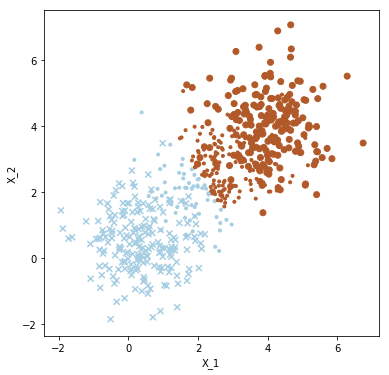

In [3]:
# Simulate data to test classifier
sim_size_per_class = 200

# Simulate two classes of bivariate gaussian data
sim_cov_mat = np.diag([0.8,0.8])
sim_c1_X = np.random.multivariate_normal([4, 4], sim_cov_mat, size=sim_size_per_class)
sim_c1_y = np.ones(sim_size_per_class)

sim_c2_X = np.random.multivariate_normal([0.5, 0.5], sim_cov_mat, size=sim_size_per_class)
sim_c2_y = np.ones(sim_size_per_class) * (-1)

# Concatenate the classes
sim_X = np.vstack((sim_c1_X, sim_c2_X))
sim_y = np.concatenate((sim_c1_y, sim_c2_y))

# Train GDA classifier
sim_params, simLabels = GDA_2Class_estimateW(sim_X, sim_y)
print("Estimated mu: ")
print(sim_params[0], "\n",sim_params[1])
print("Estimated covariance: ")
print(sim_params[2])
print("Estimated priors: ")
print(sim_params[3], sim_params[4])

# Predict training set
sim_predLabels, sim_cProbs, sim_coefs = GDA_2Class_predict(sim_X, sim_params, simLabels)


# Simulate a new dataset and see how it classifies
sim_test_X = np.random.multivariate_normal([2.5, 2.5], sim_cov_mat, size=sim_size_per_class)
sim_predTestLabels, sim_test_cProbs, sim_test_coefs = GDA_2Class_predict(sim_test_X, sim_params, simLabels)


# Plot the data
plt.figure(figsize=(6,6))
simColourmap = plt.get_cmap('Paired')
simCNorm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
# Plot the training set
plt.scatter(sim_c1_X[:,0], sim_c1_X[:,1], marker='o', cmap=simColourmap, norm=simCNorm, c=sim_predLabels[:sim_size_per_class])   
plt.scatter(sim_c2_X[:,0], sim_c2_X[:,1], marker='x', cmap=simColourmap, norm=simCNorm, c=sim_predLabels[sim_size_per_class:])   
# Plotting the test set
plt.scatter(sim_test_X[:,0], sim_test_X[:,1], marker='.', cmap=simColourmap, norm=simCNorm, c=sim_predTestLabels)   
# Labels
plt.xlabel("X_1")
plt.ylabel("X_2")

plt.show()